In [3]:
import pandas
import numpy as np
data = pandas.read_csv("TDOA与PDOA集中上传.csv")
resu = []
rolling = None
resu2 = []
for _,i in data.iterrows():
    if rolling != i['rolling']:
        if len(resu2)>0:
            resu2 = pandas.DataFrame(resu2)
            resu.append(resu2)
        rolling = i['rolling']
        resu2 = []
    resu2.append(i)
del resu2 
del rolling 
del i 
del data

In [1]:
Anchors = [0x0AFC,0x5B2B,0x08D3,0x7BD3] # 从目前收到的anchor里选择.需要保证顺序可控
tag = 0x45AF # 下拉框选择
filtwindow = 10 # 拖动条 1~100
# 以下几个校准值在配置文件里设置即可
ElectLen = 21.00 # 天线间距的电长度 单位毫米
ZeroPoint = 179.73# 角度结果的零点校准值
PhaseOffset = [0,178.99,11.61,-130.48]# 原始相位的零点校准值
Freq = 128*499.2e6 # 载波频率

In [4]:
rolling=[i['rolling'].values[0] for i in resu]
resu2 = []
# 数据按给定的anchor顺序重排
for i in resu:
    data = np.array(i[i['TagID'] == tag])
    resu2.append(np.nan + np.zeros((len(Anchors),6)))
    for j in range(len(Anchors)):
        data = np.array(i[np.logical_and(i['TagID'] == tag,i['AnchorId'] == Anchors[j])])
        if(len(data)==0):continue
        resu2[-1][np.array(Anchors)==Anchors[j],...] = np.reshape(data[None,...],(1,-1))
resu2 = np.concatenate([i[None,...] for i in resu2],0)

In [5]:
resu2.shape
TOA = resu2[:,:,3];
POA_SYNC = resu2[:,:,4];
POA_REPLY = resu2[:,:,5];
POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);

PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[:,0,None]);
PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[:,0,None]);
PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);


rolling=np.array(rolling)
temp = np.argsort(rolling)

rolling = rolling[temp]
PDOA = PDOA[temp]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\778497282.py:10: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);


In [6]:
PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(PhaseOffset)[None,...])
pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
for i in range(pdoa.shape[1]):
    pdoa[np.isfinite(pdoa[:,i]),i] = np.convolve(pdoa[np.isfinite(pdoa[:,i]),i],np.ones(21,),'same');
aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
aoa = aoa / (ElectLen /(3e11/Freq));
aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1

In [7]:
aoa_cal = np.arcsin(aoa)*180/np.pi;
aoa_cal = np.arcsin(np.sin((aoa_cal + ZeroPoint)*np.pi/180))*180/np.pi;

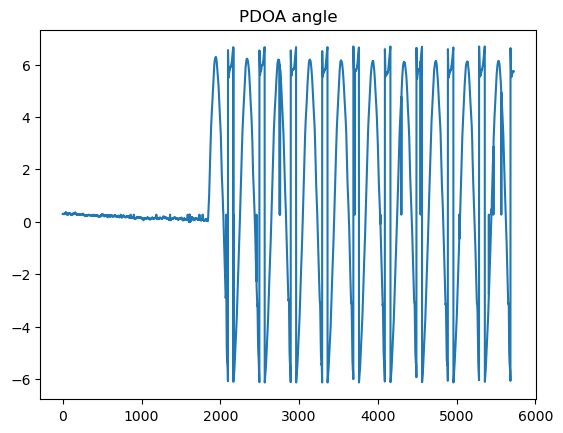

In [8]:
import matplotlib.pyplot as plt
plt.plot(aoa_cal)
plt.title("PDOA angle")
plt.show()